In [1]:
import pandas as pd
import os 
import random
import subprocess

import dask.dataframe as dd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
snps_names = pd.read_csv('../key_files/var_pos_grenenet.csv')

import pickle
with open('../key_files/blocks_snpsid_dict.pkl', 'rb') as f:
    dict_blocks = pickle.load(f)

reverse_mapping = {item: key for key, values in dict_blocks.items() for item in values}

snps_names = snps_names[snps_names['total_alleles05filter_firstgen'].notna()].reset_index(drop=True)

In [3]:
binomial_reg = pd.read_csv('../binomial_regression_lastgen/bio12_binomial_reg_results_last_gen.csv')

In [4]:
binomial_reg['block'] = binomial_reg['snp_id'].map(reverse_mapping) 

In [5]:
maf = pd.read_csv('../key_files/maf_all_samples_last_gen.csv')

In [6]:
binomial_reg = pd.concat([binomial_reg, maf],axis=1)

In [7]:
binomial_reg.columns = ['slope', 'pvalue', 'snp_id', 'block', 'MAF']

In [8]:
binomial_reg.to_csv('../binomial_regression_lastgen/bio12_binomial_reg_lastgen_wmaf.csv',index=None)

In [9]:
binomial_reg

,slope,pvalue,snp_id,block,MAF
0,-0.071916,7.601459e-08,1_346,1_0,0.288067
1,-0.094221,1.088035e-04,1_353,1_0,0.077929
2,0.072690,7.963494e-05,1_363,1_0,0.092449
3,-0.224875,9.784067e-16,1_395,1_0,0.078113
4,-0.224875,9.784067e-16,1_396,1_0,0.078113
...,...,...,...,...,...
1048630,0.186622,3.190082e-26,5_26975078,5_3110,0.169091
1048631,-0.054703,1.989126e-02,5_26975121,5_3110,0.069410
1048632,-0.054703,1.989126e-02,5_26975148,5_3110,0.069410
1048633,0.021885,6.410246e-02,5_26975272,5_3110,0.466354


In [14]:
path = '/carnegie/nobackup/scratch/tbellagio/gea_grene-net/wza_last_gen/'

In [10]:
## create a dir 


# create sbatch files to submit on cedar server
shfiles = []

seed = random.randint(1,100000000)
file = 'wza.sh'
cmd = f'python general_WZA_script_mod_polynomial_order7.py --correlations ../binomial_regression_lastgen/bio12_binomial_reg_lastgen_wmaf.csv --summary_stat pvalue --window "block" --output wza_binomial_regression_bio12_poly7.csv --sep ","'
text = f'''#!/bin/bash
#SBATCH --job-name=wza
#SBATCH --time=1:00:00  # Time limit set to 4 days
#SBATCH --ntasks=1
#SBATCH --mem-per-cpu=30gb
#SBATCH --output=wza_%j.out
#SBATCH --mail-user=tbellagio@carnegiescience.edu
#SBATCH --mail-type=FAIL

module load python/3.11_conda
conda activate /home/tbellagio/miniforge3/envs/pipeline_snakemake
export LD_LIBRARY_PATH="/home/tbellagio/miniforge3/envs/run_baypass/lib:$LD_LIBRARY_PATH"
cd /carnegie/nobackup/scratch/tbellagio/gea_grene-net/wza_last_gen
{cmd}


'''
with open(file, 'w') as o:
    o.write("%s" % text)
shfiles.append(file)

In [11]:
## now run the shfiles
for shfile in shfiles:
    # Submit each sbatch script to the SLURM scheduler
    subprocess.run(["sbatch", shfile], check=True)

Submitted batch job 57169


In [14]:
wza = pd.read_csv('wza_binomial_regression_bio12_poly7.csv')

In [15]:
wza[wza['Z_pVal'].isna()]

,gene,SNPs,hits,Z,top_candidate_p,Z_pVal
1230,1_2123,2002,36,0.770807,0.000766,NaN
1242,1_2134,2401,1,9.878765,1.000000,NaN
4562,1_5160,2303,0,-7.682360,1.000000,NaN
6783,2_576,2694,1,-19.600409,1.000000,NaN
12033,4_234,2248,18,-3.889181,0.855876,NaN
15473,5_274,2323,21,10.353020,0.707436,NaN
15901,5_331,2016,43,12.067674,0.000006,NaN
16132,5_542,2106,9,-4.359642,0.998980,NaN
16199,5_602,2427,11,18.094595,0.999119,NaN
16334,5_724,2896,2,-1.667404,1.000000,NaN


In [16]:
wza.dropna()

,gene,SNPs,hits,Z,top_candidate_p,Z_pVal
0,1_0,206,2,5.894660,0.611389,0.165290
1,1_1,3,0,-1.055806,1.000000,0.743686
2,1_10,22,0,0.721668,1.000000,0.347361
3,1_100,51,0,2.764376,1.000000,0.204280
4,1_1000,9,0,1.815625,1.000000,0.121965
...,...,...,...,...,...,...
16624,5_995,36,0,-0.701462,1.000000,0.551383
16625,5_996,3,0,1.506347,1.000000,0.108190
16626,5_997,27,0,1.581917,1.000000,0.248042
16627,5_998,6,0,-1.084203,1.000000,0.721629


In [17]:
wza['top_candidate_p'].value_counts()

top_candidate_p
1.000000e+00    15524
2.970100e-02       19
6.793465e-02       15
5.851985e-02       12
3.940399e-02       12
                ...  
1.075305e-25        1
5.223048e-05        1
8.341005e-01        1
8.428059e-01        1
9.258366e-01        1
Name: count, Length: 850, dtype: int64

In [18]:
biovar = 'bio1'

/tmp/ipykernel_2926858/788878766.py:1: RuntimeWarning: divide by zero encountered in log10
  observed_quantiles = -np.log10(np.sort(wza['Z_pVal'].values))


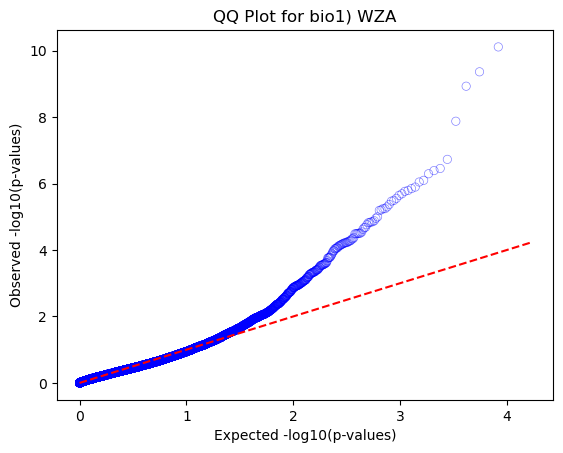

In [15]:
observed_quantiles = -np.log10(np.sort(wza['Z_pVal'].values))

# Expected quantiles from the uniform distribution
expected_quantiles = -np.log10(np.linspace(1 / len(wza), 1, len(wza)))

# QQ plot
sns.scatterplot(x = expected_quantiles, y = observed_quantiles, edgecolor='b', facecolor='none', alpha=0.5)
plt.plot([min(expected_quantiles), max(expected_quantiles)], [min(expected_quantiles), max(expected_quantiles)], 'r--')

plt.xlabel("Expected -log10(p-values)")
plt.ylabel("Observed -log10(p-values)")
plt.title(f'QQ Plot for {biovar}) WZA')

plt.show()

In [19]:
wza['chrom'] = wza['gene'].str.split('_').str[0].astype(int)
wza['pos'] = wza['gene'].str.split('_').str[1].astype(int)

In [20]:
min = wza.loc[wza['Z_pVal']!=0]['Z_pVal'].min()

In [21]:
wza.loc[wza['Z_pVal']==0]

,gene,SNPs,hits,Z,top_candidate_p,Z_pVal,chrom,pos
5582,2_1434,1997,3,7.112963,1.0,0.0,2,1434


In [22]:
#wza.loc[wza['Z_pVal']==0, 'Z_pVal'] = min

In [23]:
wza.sort_values('Z_pVal').head(50)

,gene,SNPs,hits,Z,top_candidate_p,Z_pVal,chrom,pos
5582,2_1434,1997,3,7.112963,9.999996e-01,0.000000e+00,2,1434
4247,1_4877,11,11,9.034499,1.000000e-22,2.567148e-07,1,4877
7114,2_89,35,17,15.104862,3.825260e-25,3.164883e-07,2,89
5234,2_1116,26,23,12.641999,2.525965e-43,5.902208e-07,2,1116
11789,4_2115,11,9,8.325800,5.401450e-17,1.778312e-06,4,2115
2038,1_2865,6,6,6.888824,1.000000e-12,2.234725e-06,1,2865
4224,1_4856,4,4,6.298055,1.000000e-08,2.497354e-06,1,4856
12114,4_2415,19,15,10.103520,3.732689e-27,3.156304e-06,4,2415
4512,1_5114,10,6,7.706847,2.028939e-10,4.531866e-06,1,5114
12808,4_3051,74,65,19.900050,1.011050e-119,4.701494e-06,4,3051


/home/tbellagio/miniforge3/envs/pipeline_snakemake/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_2991991/35879088.py:40: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


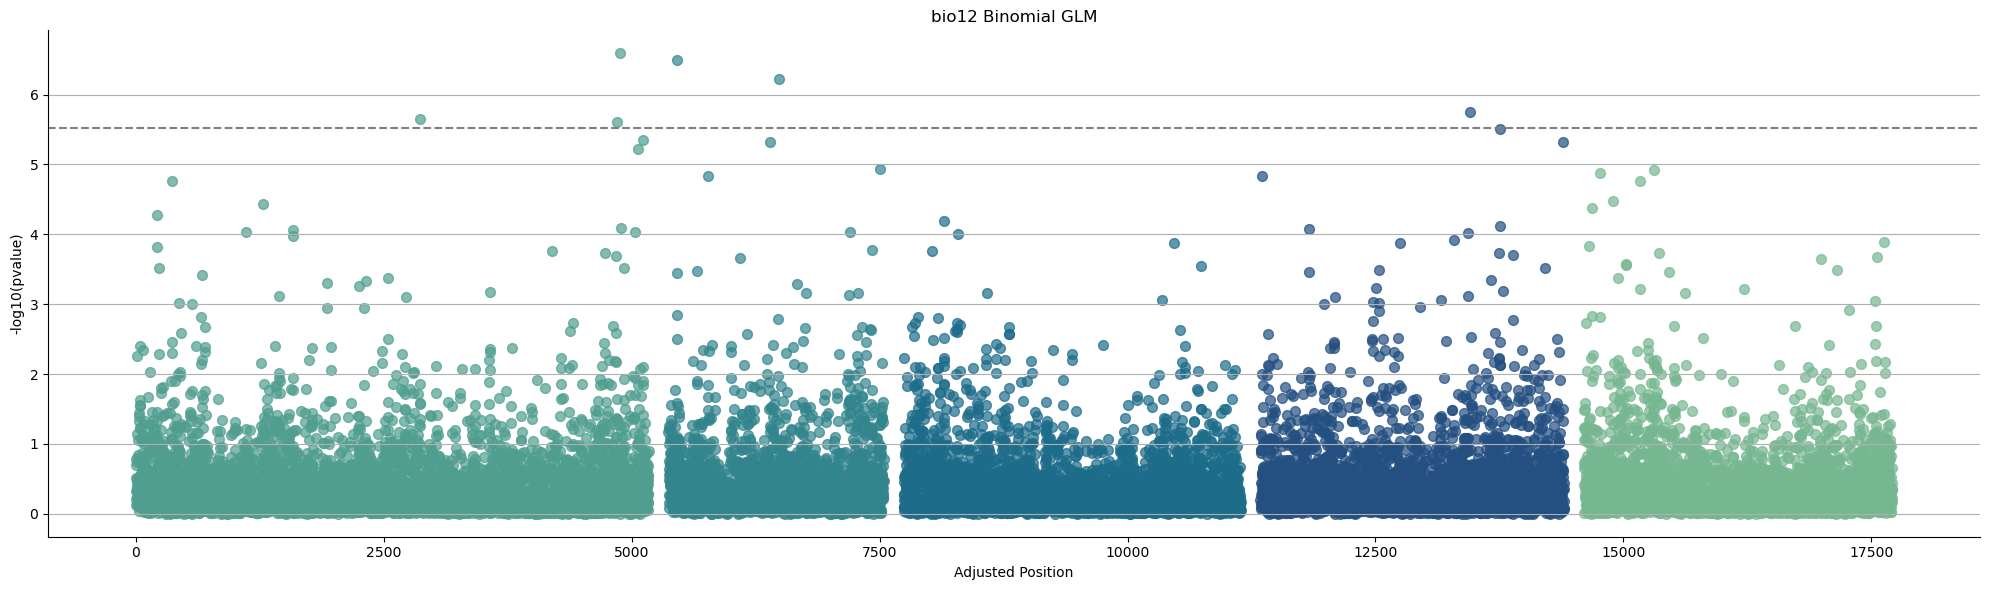

In [25]:
threshold_value = 0.05 / len(wza)
biovar='bio12'
#sm.qqplot(pvalues['pvalue'], line ='45') 
#py.show() 

df = wza[['Z_pVal','pos','chrom']].copy()


# Parsing chromosome number and position
df['chromosome'] = df['chrom']
df['position'] = df['pos']
df['-log10(pvalue)'] = -np.log10(df['Z_pVal'])

colors = sns.color_palette("crest", n_colors = 5)

# Calculate the offset for each chromosome to prevent overlap
chromosome_offsets = {}
offset = 0
for chrom in sorted(df['chromosome'].unique()):
    chromosome_offsets[chrom] = offset
    max_position = df[df['chromosome'] == chrom]['position'].max()
    offset += max_position + 200  # Buffer to prevent overlap

# Apply offsets to positions
df['adjusted_position'] = df.apply(lambda row: row['position'] + chromosome_offsets[row['chromosome']], axis=1)

# Normalize sizes for better visualization
size_transform = 2  # Adjust this factor as needed


# Create a color map based on `n_est`
#df['color'] = df['n_est'].map(lambda x: cmap(norm(x)))

# Creating the Manhattan plot
plt.figure(figsize=(20, 6))

for chrom in sorted(df['chromosome'].unique()):
    
    subset = df[df['chromosome'] == chrom]
    plt.scatter(
        subset['adjusted_position'],
        subset['-log10(pvalue)'],
        alpha=0.7,  # Transparency for better visibility
        c=colors[chrom % len(colors)], 
        label=f'Chr {chrom}',
            s= 50)

# Aesthetics
plt.xlabel('Adjusted Position')
plt.ylabel('-log10(pvalue)')
plt.title(f'{biovar} Binomial GLM')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.grid(axis='y')



# Create a legend for the number of estimated lineages
#handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(norm(n)), markersize=10, label=f'Lineages {n}') for n in sorted(n_est_unique)]
#plt.legend(handles=handles, title="Estimated Lineages", bbox_to_anchor=(1.05, 1), loc='upper left')

# Threshold line
threshold = -np.log10(threshold_value)
plt.axhline(y=threshold, color='grey', linestyle='dashed')

# Show the plot
plt.tight_layout()
plt.savefig('manhattan_bio12_binomial.pdf')
plt.savefig('manhattan_bio12_binomial.png',dpi=600)

plt.show()


In [ ]:
#genes = ['2_199', '3_2730', '5_2244']
genes = ['2_1265']
# Add circles around the specific genes
for gene in genes:
    chrom, pos = map(int, gene.split('_'))
    subset_gene = df[(df['chromosome'] == chrom) & (df['position'] == pos)]
    if not subset_gene.empty:
        plt.scatter(
            subset_gene['adjusted_position'],
            subset_gene['-log10(pvalue)'],
            edgecolor='red',  # Color of the edge of the circle
            linewidth=2,      # Width of the edge line
            facecolor='none', # Facecolor of the circle (None means transparent)
            s=100,            # Size of the circle
            label=f'Gene {gene}'
        )

In [ ]:
#genes = ['2_199', '3_2730', '5_2244']
genes = ['2_1265', '4_801']
# Add circles around the specific genes
for gene in genes:
    chrom, pos = map(int, gene.split('_'))
    subset_gene = df[(df['chromosome'] == chrom) & (df['position'] == pos)]
    if not subset_gene.empty:
        plt.scatter(
            subset_gene['adjusted_position'],
            subset_gene['-log10(pvalue)'],
            edgecolor='red',  # Color of the edge of the circle
            linewidth=2,      # Width of the edge line
            facecolor='none', # Facecolor of the circle (None means transparent)
            s=100,            # Size of the circle
            label=f'Gene {gene}'
        )

/tmp/ipykernel_3175312/1489910986.py:31: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(subset['adjusted_position'], subset['-log10(pvalue)'], c=colors[chrom % len(colors)], label=f'Chr {chrom}', s=10)


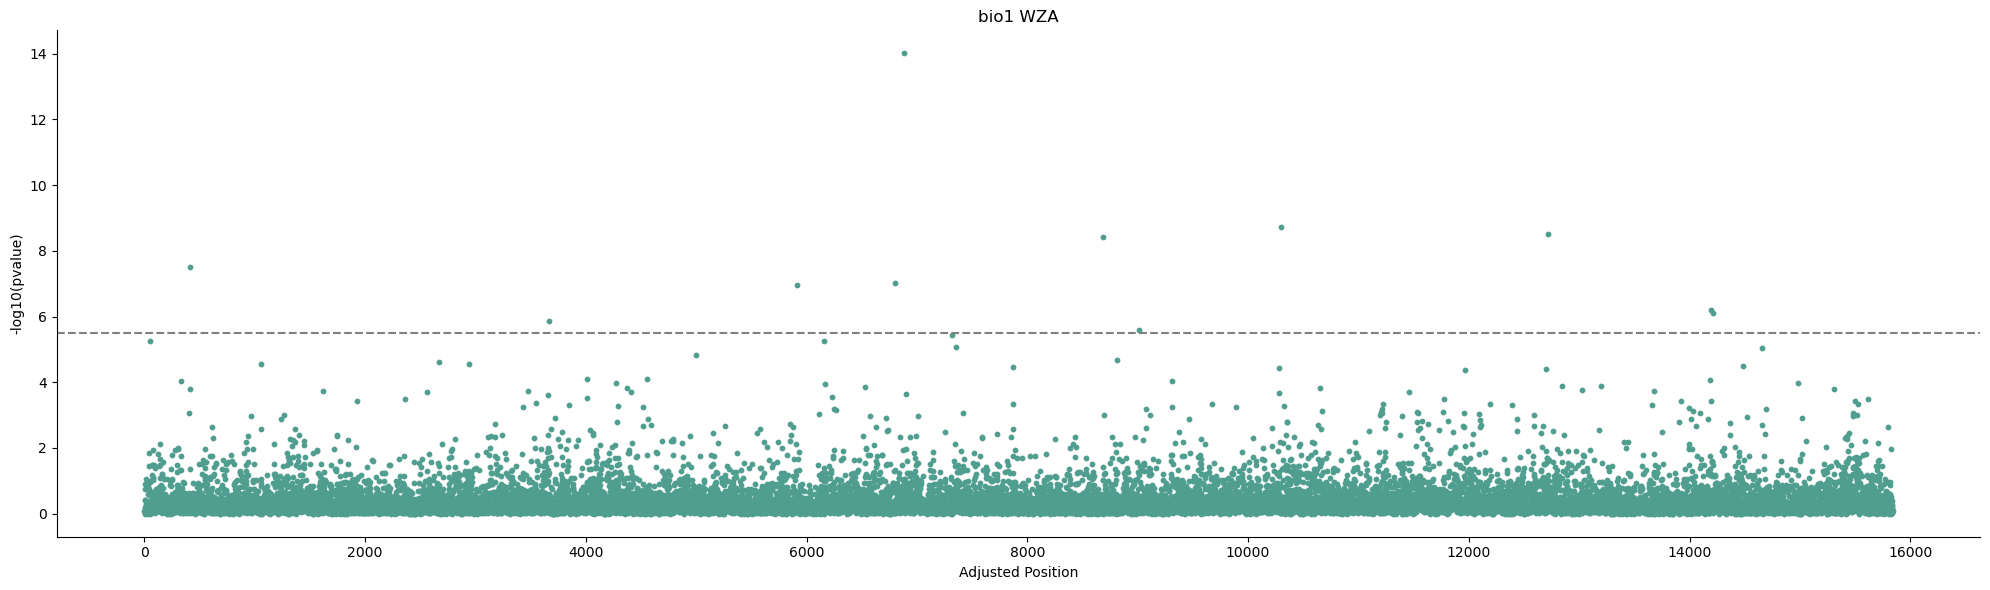

In [54]:
threshold_value = 0.05 / len(wza)
biovar='bio1'
#sm.qqplot(pvalues['pvalue'], line ='45') 
#py.show() 

df = wza[['Z_pVal', 'index']].copy()

colors = sns.color_palette("crest", n_colors = 5)

# Parsing chromosome number and position
df['chromosome'] = 1
df['position'] = df['index']
df['-log10(pvalue)'] = -np.log10(df['Z_pVal'])

# Calculate the offset for each chromosome to prevent overlap
chromosome_offsets = {}
offset = 0
for chrom in sorted(df['chromosome'].unique()):
    chromosome_offsets[chrom] = offset
    max_position = df[df['chromosome'] == chrom]['position'].max()
    offset += max_position + 1000000  # Adding 1 million as a buffer between chromosomes

# Apply offsets to positions
df['adjusted_position'] = df.apply(lambda row: row['position'] + chromosome_offsets[row['chromosome']], axis=1)

# Creating the Manhattan plot
plt.figure(figsize=(20, 6))

for chrom in sorted(df['chromosome'].unique()):
    subset = df[df['chromosome'] == chrom]
    plt.scatter(subset['adjusted_position'], subset['-log10(pvalue)'], c=colors[chrom % len(colors)], label=f'Chr {chrom}', s=10)

# Aesthetics
plt.xlabel('Adjusted Position')
plt.ylabel('-log10(pvalue)')
#plt.title('Manhattan Plot')
#plt.grid(axis='y')
#plt.legend(title="Chromosome", bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)  # Remove the top spine
ax.spines['right'].set_visible(False)
# Threshold line (optional)
threshold = -np.log10(threshold_value)
plt.axhline(y=threshold, color='grey', linestyle='dashed')
plt.title(f'{biovar} WZA')  # Set the title

# Show the plot
plt.tight_layout()
#plt.savefig(f'manhattan_{biovar}.png')
plt.show()

/tmp/ipykernel_3175312/2368688080.py:31: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(subset['adjusted_position'], subset['-log10(pvalue)'], c=colors[chrom % len(colors)], label=f'Chr {chrom}', s=10)


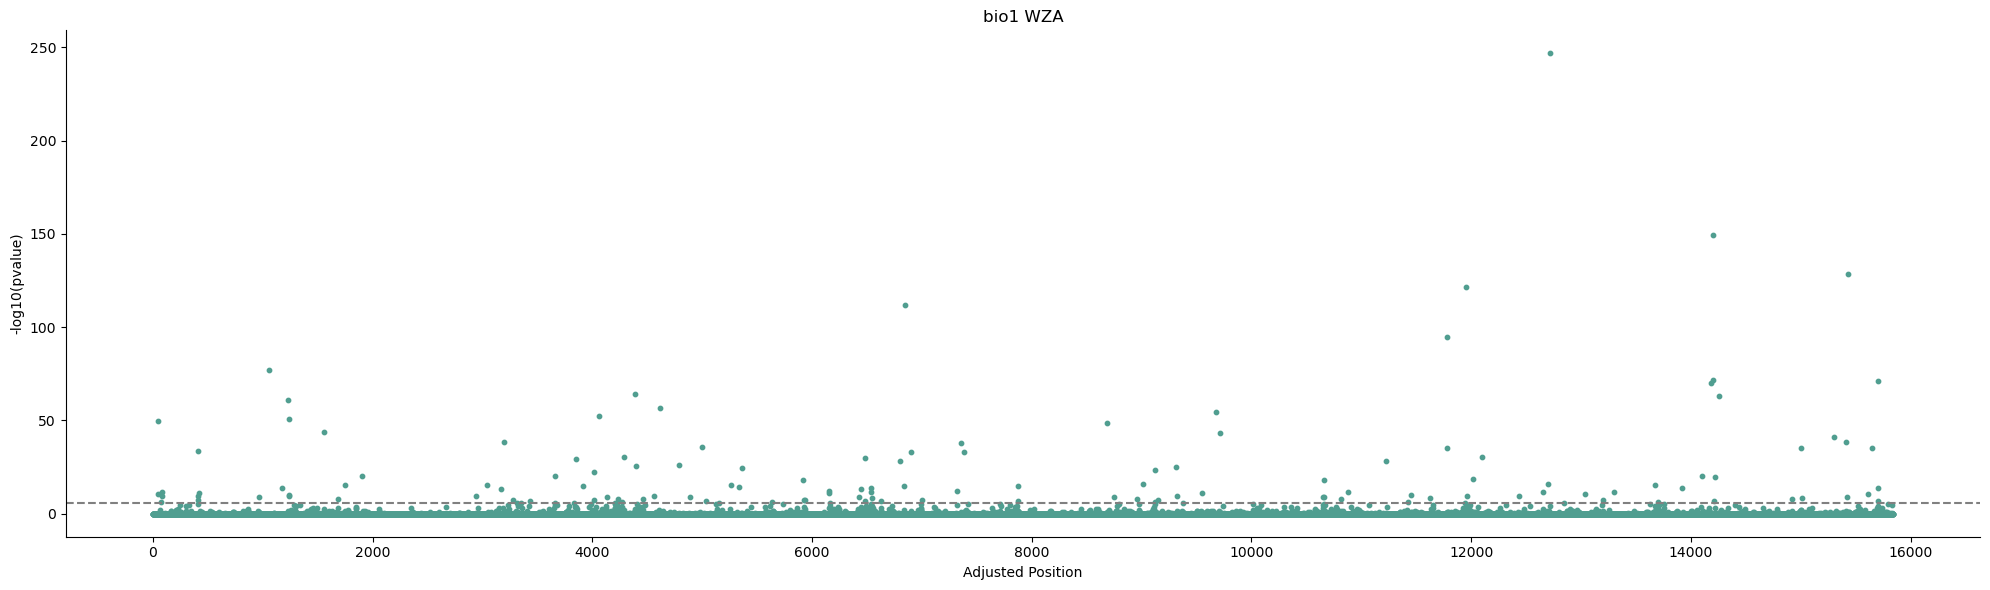

In [50]:
threshold_value = 0.05 / len(wza)
biovar='bio1'
#sm.qqplot(pvalues['pvalue'], line ='45') 
#py.show() 

df = wza[['top_candidate_p', 'index']].copy()

colors = sns.color_palette("crest", n_colors = 5)

# Parsing chromosome number and position
df['chromosome'] = 1
df['position'] = df['index']
df['-log10(pvalue)'] = -np.log10(df['top_candidate_p'])

# Calculate the offset for each chromosome to prevent overlap
chromosome_offsets = {}
offset = 0
for chrom in sorted(df['chromosome'].unique()):
    chromosome_offsets[chrom] = offset
    max_position = df[df['chromosome'] == chrom]['position'].max()
    offset += max_position + 1000000  # Adding 1 million as a buffer between chromosomes

# Apply offsets to positions
df['adjusted_position'] = df.apply(lambda row: row['position'] + chromosome_offsets[row['chromosome']], axis=1)

# Creating the Manhattan plot
plt.figure(figsize=(20, 6))

for chrom in sorted(df['chromosome'].unique()):
    subset = df[df['chromosome'] == chrom]
    plt.scatter(subset['adjusted_position'], subset['-log10(pvalue)'], c=colors[chrom % len(colors)], label=f'Chr {chrom}', s=10)

# Aesthetics
plt.xlabel('Adjusted Position')
plt.ylabel('-log10(pvalue)')
#plt.title('Manhattan Plot')
#plt.grid(axis='y')
#plt.legend(title="Chromosome", bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)  # Remove the top spine
ax.spines['right'].set_visible(False)
# Threshold line (optional)
threshold = -np.log10(threshold_value)
plt.axhline(y=threshold, color='grey', linestyle='dashed')
plt.title(f'{biovar} WZA')  # Set the title

# Show the plot
plt.tight_layout()
plt.savefig(f'manhattan_{biovar}.png')
plt.show()